# Task 3 – Evaluación de Ingenería y Criterio

En esta parte se evaluará la aplicación de sus algoritmos en situaciones reales. Use imágenes propias o
descargue un datase de “suelos de almacén” o “carreteras con textura”.

### Experimento A: El efecto de Sigm (σ)
Cargue una imagen con ruido (agregue ruido "Sal y Pimienta" o Gaussiano artificialmente a una foto limpia si es necesario).

1- Genere 3 versiones de detección de bordes (Magnitud Sobel) variando el pre-procesamiento
Gaussiano:

a. Sin suavizado.

b. Gaussiano 𝜎 = 1 (kernel sugerido 5x5).

c. Gaussiano 𝜎 = 5 (kernel sugerido 31x31).


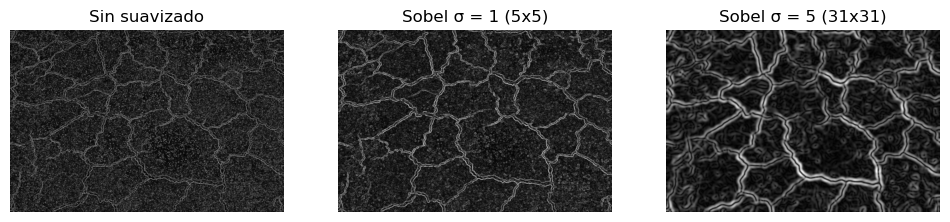

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

path = "tierra.jpg"   
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise FileNotFoundError("No se pudo cargar la imagen")

img = img.astype(np.float32)

def ruido_sal_pimienta(img, prob=0.03, seed=1):
    rng = np.random.default_rng(seed)
    out = img.copy()
    h, w = out.shape
    n = int(prob * h * w)

    idx = rng.choice(h * w, n, replace=False)
    r = idx // w
    c = idx % w

    mitad = n // 2
    out[r[:mitad], c[:mitad]] = 255
    out[r[mitad:], c[mitad:]] = 0
    return out

img_ruido = ruido_sal_pimienta(img)

def padding_manual(img, pad):
    return np.pad(img, ((pad, pad), (pad, pad)), mode="reflect")

def mi_convolucion(img, kernel):
    k = np.flipud(np.fliplr(kernel))
    kh, kw = k.shape
    pad = kh // 2

    img_p = padding_manual(img, pad)
    ventanas = sliding_window_view(img_p, (kh, kw))
    salida = np.einsum("ijkl,kl->ij", ventanas, k)

    return salida.astype(np.float32)

def kernel_gaussiano(tam, sigma):
    ax = np.arange(-(tam//2), tam//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    g = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return g / g.sum()

def sobel_magnitud(img):
    Gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32)
    Gy = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=np.float32)

    gx = mi_convolucion(img, Gx)
    gy = mi_convolucion(img, Gy)

    mag = np.sqrt(gx**2 + gy**2)
    mag = (mag / mag.max()) * 255
    return mag

bordes_sin = sobel_magnitud(img_ruido)

k1 = kernel_gaussiano(5, 1)
img_s1 = mi_convolucion(img_ruido, k1)
bordes_s1 = sobel_magnitud(img_s1)

k5 = kernel_gaussiano(31, 5)
img_s5 = mi_convolucion(img_ruido, k5)
bordes_s5 = sobel_magnitud(img_s5)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(bordes_sin, cmap="gray")
plt.title("Sin suavizado")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(bordes_s1, cmap="gray")
plt.title("Sobel σ = 1 (5x5)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(bordes_s5, cmap="gray")
plt.title("Sobel σ = 5 (31x31)")
plt.axis("off")

plt.show()


2- Análisis: Muestre las tres imágenes de bordes resultantes. 

- ¿Qué pasa con los bordes finos cuando σ es muy alto? Los bordes extremadamente finos se eliminan, mientras que los bordes grandes se mantienen pero se ven más gruesos.

- ¿Qué pasa con la textura del suelo cuando no hay suavizado? La textura del suelo genera muchos bordes falsos, haciendo la imagen muy ruidosa.

- Como ingeniero, ¿cuál elegiría para detectar pallets grandes ignorando grietas pequeñas en el suelo? Elegiría σ = 5, porque elimina la textura y grietas pequeñas, y resalta solo las estructuras grandes.

### Experimento B: Histéresis Manual (Simulación de Canny)

Usted ha calculado la Magnitud del Gradiente en el paso 3.3. Ahora implemente una función simple de umbralización umbral_simple(magnitud, T) y compare visualmente con cv2.Canny.

1. Intente encontrar un valor T único que limpie el ruido pero mantenga los bordes: Seleccionamos a  T = 80 porque con valores más bajos (como 20–40) queda mucho ruido, y con valores más altos (como 100) se empiezan a perder partes del borde. Con 80 se ve más limpio y aún se conservan la mayoría de grietas.

2. Observe el resultado: ¿Se rompen las líneas de los bordes? Sí, estos se van rompiendo porco a poco, pero a pesar de todo el ruido que se puede apreciar es mucho menos pero se ven cortados en ciertos puntos.

3. Pregunta Crítica: Explique por qué un simple umbral de corte (Thresholding) nunca será tan efectivo como el método de Histéresis usado en Canny. ¿Qué problema específico resuelve la conectividad de la histéresis en el contexto de un robot moviéndose y vibrando (lo que causa cambios leves de iluminación en los bordes)?  Un umbral simple puede cortar los bordes cuando la iluminación cambia un poco. La histéresis de Canny usa conectividad: mantiene bordes débiles si están conectados a uno fuerte. En un robot que vibra, esto evita que los bordes se rompan o parpadeen.

Usando magnitud Sobel con σ = 1


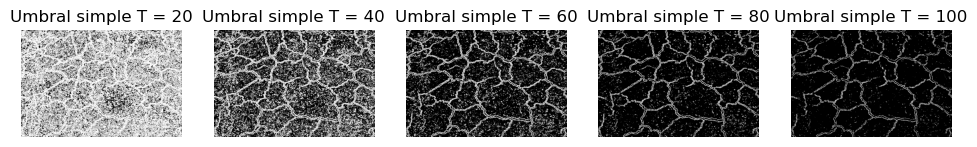

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

if "bordes_s1" in globals():
    mag = bordes_s1
    print("Usando magnitud Sobel con σ = 1")
elif "bordes_s5" in globals():
    mag = bordes_s5
    print("Usando magnitud Sobel con σ = 5")
else:
    raise NameError("No se encontró ninguna magnitud Sobel")

def umbral_simple(magnitud, T):
    out = np.zeros_like(magnitud, dtype=np.uint8)
    out[magnitud >= T] = 255
    return out

Ts = [20, 40, 60, 80, 100]
resultados = [umbral_simple(mag, T) for T in Ts]

plt.figure(figsize=(12,4))
for i, (T, img) in enumerate(zip(Ts, resultados), 1):
    plt.subplot(1, len(Ts), i)
    plt.imshow(img, cmap="gray")
    plt.title(f"Umbral simple T = {T}")
    plt.axis("off")

plt.show()
